In [1]:
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'svg'

In [49]:
import restaurants_timeseries.core as core
import restaurants_timeseries.surveyors as surveyors

import GPy
import plotnine as pn
import pandas as pd
import numpy as np
from typing import List
from mizani.formatters import date_format
from fastcore.foundation import patch
import warnings

In [50]:
pn.options.figure_size = figure_size=(15, 4)
RESPONSE = 'visitors'
PREDICTORS = ['day']
VAL_DAYS = 45

def plot_single_timeseries(dat: pd.DataFrame):
    return (
        pn.ggplot(dat, pn.aes('visit_date', 'visitors', color='dataset')) +
        pn.geom_line(pn.aes(group='air_store_id')) +
        pn.scale_x_date(breaks="1 week", labels=date_format("%b %d '%y")) +
        pn.theme_bw() +
        pn.theme(axis_text_x=pn.element_text(angle=90*3, size=9),
                 panel_grid=pn.element_blank(),
                 legend_position="top", legend_title=pn.element_blank()))

def make_predictions_frame(days: List[int], means: List[float], 
                           variance: List[float]) -> pd.DataFrame:
    pred_dat = pd.DataFrame({'day': days, 'mean': means, 'var': variance, 'sd': np.sqrt(variance)})
    pred_dat.loc[:, 'mean'] = np.maximum(0.0, pred_dat['mean'])
    pred_dat.loc[:, 'lower_bound'] = np.maximum(0.0, pred_dat['mean'] - 2 * pred_dat['sd'])
    pred_dat.loc[:, 'upper_bound'] = np.maximum(0.0, pred_dat['mean'] + 2 * pred_dat['sd'])
    return pred_dat


class Set:
    def __init__(self, dat, predictors = PREDICTORS, response: str = RESPONSE):
        self.data = dat.copy()
        self.X = dat[predictors].to_numpy()
        self.y = dat[[response]].to_numpy()


@patch
def split_datasets(self: surveyors.VisitsSurveyor, val_days: int):
    """
    Splits self.visits into Training and Validation sets, setting the fields `trn` and `val`.
    Also adds the column `dataset` to self.visits.
    """    
    if len(self.visits['air_store_id'].unique()) > 1:
        raise ValueError(
            "This class only supports a dataframe of a single 'air_store_id' right now.")
    earliest = surveyors.get_earliest_date(self.visits)
    latest = surveyors.get_latest_date(self.visits)
    self.visits['dataset'] = ['Training' if (latest - visit_date).days >= val_days else 'Validation'
                              for visit_date in self.visits['visit_date']]
    split_counts = dict(vs.visits.groupby('dataset').count()['air_store_id'])    
    if split_counts['Validation'] != val_days:
        warnings.warn(f"Expected to find {val_days} days in the validation set, " +
                      f"but found {split_counts['Validation']} instead.")
    if split_counts['Training'] < split_counts['Validation']:
        warnings.warn(f"Less training days than validation days: {split_counts}.")
    assert self.visits['dataset'].count()
    
    self.trn = Set(self.visits.query("dataset == 'Training'"))
    self.val = Set(self.visits.query("dataset == 'Validation'"))


In [51]:
single_store_dat = (
    core.data['visits']
    .query(f"air_store_id == '{surveyors.populated_store_id}'")
    .copy())
vs = surveyors.VisitsSurveyor(single_store_dat, False)
vs.visits.loc[:, 'day'] = range(vs.visits.shape[0])
vs.split_datasets(VAL_DAYS)

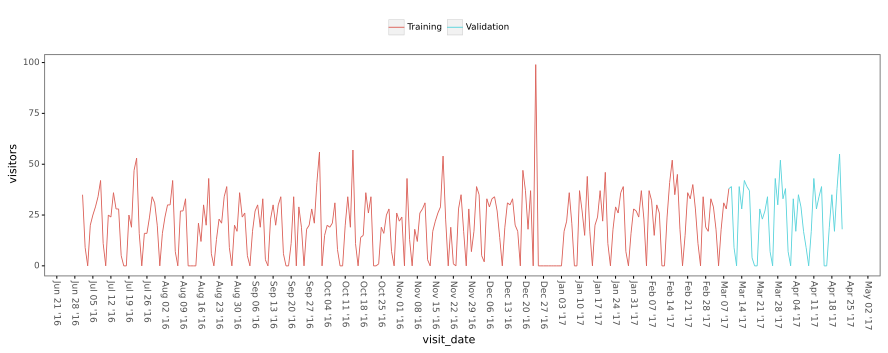

<ggplot: (8668618618100)>

In [52]:
plot_single_timeseries(vs.visits)

In [ ]:
X = vs.visits[['day']].to_numpy()
base_kernel = GPy.kern.RBF(input_dim=X.shape[1], variance=10.0, lengthscale=1.0)
periodic_kernel = GPy.kern.PeriodicMatern32(input_dim=1, variance=1., period=7.0)
kernel = base_kernel + periodic_kernel
y = vs.visits[['visitors']].to_numpy()

In [ ]:
m = GPy.models.GPRegression(X, y, kernel)

In [ ]:
m.plot()

In [ ]:
p = m.predict(X)
means = [x[0] for x in p[0]]
variance = [x[0] for x in p[1]]
days = [x[0] for x in X]

In [ ]:

(
    pn.ggplot() +
    pn.geom_line(data=vs.visits, mapping=pn.aes('day', 'visitors'), color='gray') +
    pn.geom_ribbon(data=pred_dat, mapping=pn.aes(x='day', ymax='upper_bound', ymin='lower_bound'), 
                   fill='pink', alpha=0.8) +
    pn.geom_line(data=pred_dat, mapping=pn.aes(x='day', y='mean'), color='maroon') +
    pn.theme_bw())